<a href="https://colab.research.google.com/github/Mohamed-said-salah/satellite-segmentation-unet/blob/main/notebooks/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install torch torchvision torchaudio opencv-python pillow matplotlib tqdm

import os, glob, random, numpy as np, cv2, matplotlib.pyplot as plt, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Device: cuda


In [2]:
# Create tiny synthetic dataset (guaranteed to run fast)
os.makedirs('data/images', exist_ok=True)
os.makedirs('data/masks', exist_ok=True)

def synth_image(size=256):
    img = np.zeros((size, size, 3), dtype=np.uint8)
    mask = np.zeros((size, size), dtype=np.uint8)
    for _ in range(np.random.randint(2,5)):
        x1,y1 = np.random.randint(0,size//2,2)
        x2,y2 = x1+np.random.randint(size//4,size-10), y1+np.random.randint(size//4,size-10)
        color = np.random.randint(50,200, size=3)
        cv2.rectangle(img, (x1,y1), (x2,y2), color.tolist(), -1)
        cv2.rectangle(mask, (x1,y1), (x2,y2), 255, -1)
    noise = np.random.randint(0,30,(size,size,3),dtype=np.uint8)
    img = cv2.add(img, noise)
    return img, mask

if len(glob.glob('data/images/*.png')) < 200:
    for i in range(240):
        im, mk = synth_image(256)
        cv2.imwrite(f'data/images/{i:04d}.png', im)
        cv2.imwrite(f'data/masks/{i:04d}.png', mk)

print("Sample images:", len(glob.glob('data/images/*.png')))

Sample images: 240


In [3]:
class SegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_paths = sorted(glob.glob(os.path.join(img_dir, '*.png')))
        self.mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.png')))
        self.t = transform

    def __len__(self): return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])[:,:,::-1]
        mask = cv2.imread(self.mask_paths[idx], 0)
        img = img.astype(np.float32)/255.0
        mask = (mask>127).astype(np.float32)
        if self.t:
            img = self.t(img)
        img = torch.from_numpy(img.transpose(2,0,1))
        mask = torch.from_numpy(mask).unsqueeze(0)
        return img, mask

transform = None

all_idx = list(range(240))
random.seed(42); random.shuffle(all_idx)
train_ids = all_idx[:200]; val_ids = all_idx[200:]

def subset(ds, ids):
    ds.img_paths = [ds.img_paths[i] for i in ids]
    ds.mask_paths= [ds.mask_paths[i] for i in ids]
    return ds

full = SegDataset('data/images','data/masks', transform)
train_ds = subset(SegDataset('data/images','data/masks', transform), train_ids)
val_ds   = subset(SegDataset('data/images','data/masks', transform), val_ids)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_c=3, out_c=1):
        super().__init__()
        self.d1 = DoubleConv(in_c, 64)
        self.d2 = DoubleConv(64, 128)
        self.d3 = DoubleConv(128, 256)
        self.d4 = DoubleConv(256, 512)
        self.u3 = DoubleConv(256+512, 256)
        self.u2 = DoubleConv(128+256, 128)
        self.u1 = DoubleConv(64+128, 64)
        self.out = nn.Conv2d(64, out_c, 1)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x1 = self.d1(x)
        x2 = self.d2(self.pool(x1))
        x3 = self.d3(self.pool(x2))
        x4 = self.d4(self.pool(x3))
        u3 = torch.cat([nn.functional.interpolate(x4, scale_factor=2, mode='bilinear', align_corners=False), x3], 1); u3 = self.u3(u3)
        u2 = torch.cat([nn.functional.interpolate(u3, scale_factor=2, mode='bilinear', align_corners=False), x2], 1); u2 = self.u2(u2)
        u1 = torch.cat([nn.functional.interpolate(u2, scale_factor=2, mode='bilinear', align_corners=False), x1], 1); u1 = self.u1(u1)
        return self.out(u1)

model = UNet().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
bce = nn.BCEWithLogitsLoss()

def iou_score(pred, mask, thr=0.5, eps=1e-7):
    pred = (torch.sigmoid(pred) > thr).float()
    inter = (pred*mask).sum((1,2,3))
    union = (pred+mask - pred*mask).sum((1,2,3)) + eps
    return (inter/union).mean().item()

In [5]:
best_iou = 0.0
for epoch in range(10):
    model.train()
    tr_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        logits = model(x)
        loss = bce(logits, y)
        loss.backward(); opt.step()
        tr_loss += loss.item()*x.size(0)
    tr_loss /= len(train_loader.dataset)

    model.eval()
    va_loss, va_iou = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            va_loss += bce(logits, y).item()*x.size(0)
            va_iou += iou_score(logits, y)*x.size(0)
    va_loss /= len(val_loader.dataset)
    va_iou  /= len(val_loader.dataset)

    print(f"Epoch {epoch+1:02d} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | val_mIoU={va_iou:.4f}")

    if va_iou > best_iou:
        best_iou = va_iou
        torch.save(model.state_dict(), "best_unet.pt")

Epoch 01 | train_loss=0.1526 | val_loss=0.1426 | val_mIoU=0.9566
Epoch 02 | train_loss=0.0616 | val_loss=0.0543 | val_mIoU=0.9996
Epoch 03 | train_loss=0.0326 | val_loss=0.0281 | val_mIoU=0.9999
Epoch 04 | train_loss=0.0202 | val_loss=0.0163 | val_mIoU=0.9999
Epoch 05 | train_loss=0.0139 | val_loss=0.0120 | val_mIoU=0.9999
Epoch 06 | train_loss=0.0109 | val_loss=0.0085 | val_mIoU=0.9999
Epoch 07 | train_loss=0.0084 | val_loss=0.0065 | val_mIoU=0.9999
Epoch 08 | train_loss=0.0061 | val_loss=0.0057 | val_mIoU=0.9999
Epoch 09 | train_loss=0.0052 | val_loss=0.0041 | val_mIoU=1.0000
Epoch 10 | train_loss=0.0044 | val_loss=0.0037 | val_mIoU=1.0000


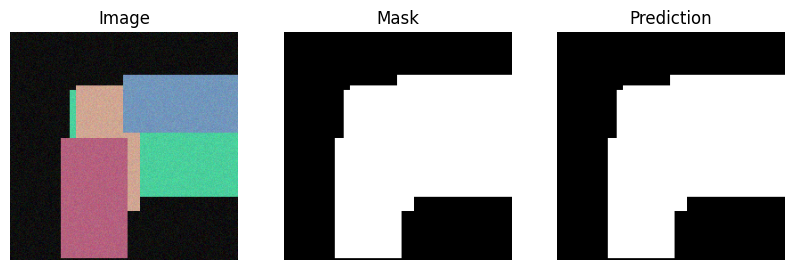

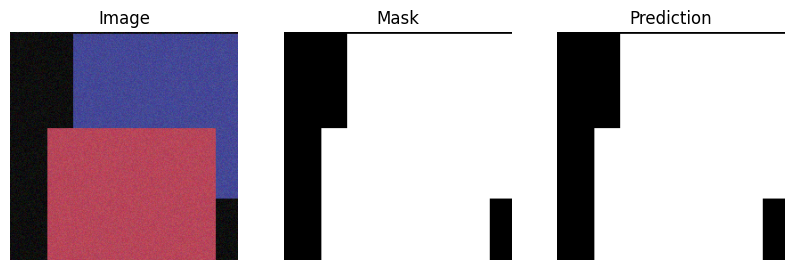

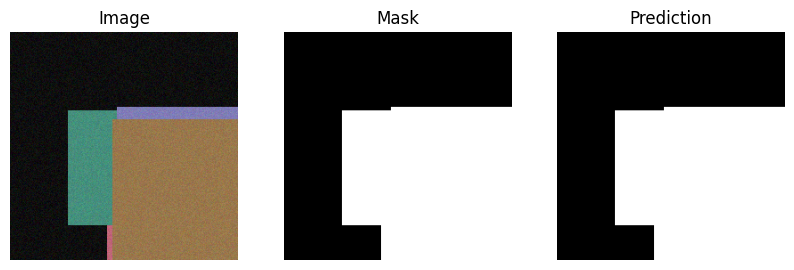

In [6]:
model.load_state_dict(torch.load("best_unet.pt", map_location=device))
model.eval()
x, y = next(iter(val_loader))
with torch.no_grad():
    pred = torch.sigmoid(model(x.to(device))).cpu()

for i in range(3):
    img = (x[i].permute(1,2,0).numpy()*255).astype(np.uint8)
    msk = (y[i,0].numpy()*255).astype(np.uint8)
    prd = (pred[i,0].numpy()>0.5).astype(np.uint8)*255
    fig,ax = plt.subplots(1,3,figsize=(10,4))
    ax[0].imshow(img); ax[0].set_title('Image'); ax[0].axis('off')
    ax[1].imshow(msk, cmap='gray'); ax[1].set_title('Mask'); ax[1].axis('off')
    ax[2].imshow(prd, cmap='gray'); ax[2].set_title('Prediction'); ax[2].axis('off')
    plt.show()